In [1]:
import os
from pprint import pprint
import pandas as pd 
import numpy as np
from nltk import WordNetLemmatizer
from sklearn.metrics import log_loss
import enchant
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk import WordPunctTokenizer
import math
from IPython.display import clear_output 
from num2words import num2words
from nltk.tokenize import RegexpTokenizer
from decimal import Decimal
from word2number import w2n
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import random
import seaborn as sns
import copy
random.seed(0)
%matplotlib inline
# plt.rcParams['figure.figsize'] = [8, 8]
sns.set(style = "darkgrid")

%run functions.ipynb

In [2]:
stop_ws = set(stopwords.words('english'))
d = enchant.Dict("en_US")
path = "dataset/"
renamed = False

In [3]:
# if(not renamed):
#     rename_documents(path)
#     renamed = True

docs, docs_label = collect_documents(path)

C = 5

In [27]:
data = pd.DataFrame.from_dict(docs, orient = 'index', columns = ['text'])
data['doc_id'] = data.index
data['class'] = docs_label
data = data.sample(frac=1).reset_index(drop=True)

""" Randomly split data, to get train and test set """
split_percentage = 50 # train set %
# train_data, test_data = splitDataset(data, split_percentage)
nr = int((split_percentage/100)*data.shape[0])

train_data = data.iloc[:nr, :]
test_data = data.iloc[nr:, :]

train_data, test_data, priors = convertLabels(train_data, test_data)

test_data.reset_index(drop = True, inplace = True)
train_data.reset_index(drop = True, inplace = True)
total_docs = train_data.shape[0]

sci.med               522
comp.graphics         519
sci.space             492
talk.politics.misc    488
rec.sport.hockey      479
Name: class, dtype: int64
['comp.graphics', 'rec.sport.hockey', 'sci.med', 'sci.space', 'talk.politics.misc']
[0.2076, 0.1916, 0.2088, 0.1968, 0.1952]


In [28]:
token_docId = []

for i in range(0, train_data.shape[0]):
    document = train_data.loc[i,'text']
    for token in tokenizeDocument(document):
        token_docId.append([token, train_data.loc[i, 'doc_id'], train_data.loc[i, 'class']])
        
token_docId = pd.DataFrame(token_docId, columns = ['token', 'doc_id', 'class'])        

token_docId = pd.DataFrame(token_docId, columns = ['token', 'doc_id', 'class'])
token_docId =  token_docId.sort_values(by=['token'])

inverted_index, class_index = makeIndex(token_docId, C)
# old_inverted_index = makeIndexQ2(token_docId)



In [29]:
print(len(inverted_index))
V = len(inverted_index.keys())

# print("Vocab : ", V )

16087


In [30]:
test_docs = testDataTokens(test_data['text']) # convert test data docs to tokens

In [31]:
likelihood = trainNB(inverted_index)

In [32]:
def classify(all_docs, inverted_index, likelihood):
     
    predicted_class = []
    
    for doc in all_docs:
        p = [1]*C
        for c in range(0, C):
            for term in doc:            
                if(term in inverted_index.keys()):
                    p[c]+=math.log(likelihood.loc[c, term], 10)
                else:
                    p[c]+=math.log((1/(class_index[c] + V)), 10)
            
            p[c]+=math.log(priors[c], 10)
        predicted_class.append(p.index(max(p)))
                
    return predicted_class
    
    
    

In [33]:
predicted_class = classify(test_docs, inverted_index, likelihood)

Accuracy using 50 % training data  97.88 %.


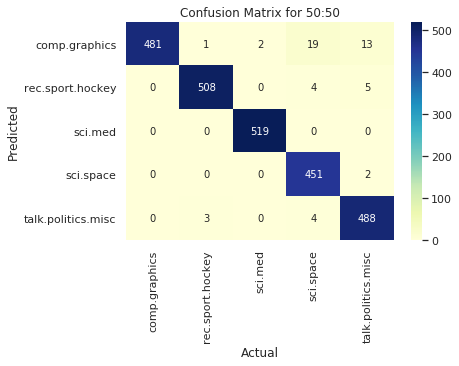

In [34]:
conf_mat = findAccuracy(predicted_class, test_data)
print('Accuracy using',split_percentage, '% training data ', (np.trace(conf_mat)/np.sum(conf_mat))*100, '%.')
drawConfusionMatrix(conf_mat, str(split_percentage) +':'+ str(100 - split_percentage))

In [18]:
""" Feature Selection Q2. """
new_feature_index = featureSelect(old_inverted_index, total_docs)

Current progress:  98.78


In [19]:
term_utility = pd.DataFrame(new_feature_index, columns = ['term', 'tfidf'])

print('# total features: ', len(old_inverted_index))
# topfeat = int(input(' Enter required features(%): '))

term_utility = term_utility.groupby('term', as_index =False).max()

term_utility = term_utility.sort_values(['tfidf'], ascending = [False])
term_utility.reset_index(drop = True, inplace =True)

topfeat = list(range(10,100,10))
results = []

for feat in topfeat:
    topft = int((feat*term_utility.shape[0])/100)
    reduced_vocab_terms = term_utility.iloc[:topft,:]['term'].values
    results.append(runQ2(feat, reduced_vocab_terms))

# total features:  56729
Accuracy for  70:30  with top 10% features:  84.06666666666666%.
Accuracy for  70:30  with top 20% features:  94.0%.
Accuracy for  70:30  with top 30% features:  95.86666666666666%.
Accuracy for  70:30  with top 40% features:  96.33333333333334%.
Accuracy for  70:30  with top 50% features:  96.6%.
Accuracy for  70:30  with top 60% features:  96.66666666666667%.
Accuracy for  70:30  with top 70% features:  96.66666666666667%.
Accuracy for  70:30  with top 80% features:  96.66666666666667%.
Accuracy for  70:30  with top 90% features:  96.73333333333333%.


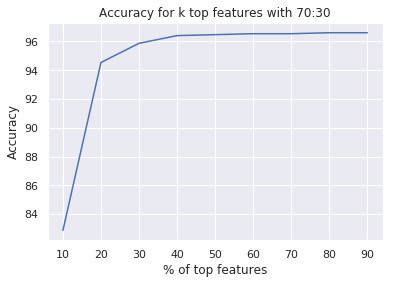

In [437]:
results = sorted(results)
sns.lineplot(topfeat, results)
plt.xlabel('% of top features')
plt.ylabel('Accuracy')
plt.title('Accuracy for k top features with 70:30')
plt.show()